In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timezone
import ipaddress
from collections import Counter

from tqdm import tqdm

from sklearn.metrics import (
    silhouette_score as sil_,
    silhouette_samples,
    calinski_harabasz_score as calinski_,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, ReLU, Add
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from tensorflow.keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")
from sklearn.ensemble import RandomForestClassifier

In [2]:
import os
def load_data(directory):
    data = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, file))
            data.append(df)
    return pd.concat(data, ignore_index=True)

df = load_data('data/cic')
# Clean column names (in case of whitespace)
df.columns = df.columns.str.strip()

df = df[df['Label'] != 'BENIGN']

features = df.select_dtypes(include=[np.number]).copy()
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)
df = df.loc[features.index].copy()

 38%|███▊      | 3/8 [00:02<00:04,  1.06it/s]


KeyboardInterrupt: 

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df["Label"].value_counts()

Label
DoS Hulk                      230124
PortScan                      158804
DDoS                          128025
DoS GoldenEye                  10293
FTP-Patator                     7935
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1956
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

In [ ]:
def group_attack_label(label):
    if label == "BENIGN":
        return "Benign"
    elif "DDoS" in label:
        return "DDoS"
    elif "DoS" in label:
        return "DoS"
    elif "PortScan" in label:
        return "Scan"
    elif "Patator" in label:
        return "BruteForce"
    elif "Web Attack" in label:
        return "WebAttack"
    elif label in ["Bot", "Infiltration", "Heartbleed"]:
        return "Other"
    else:
        return "Unknown"

df['label_group'] = df['Label'].apply(group_attack_label)

In [ ]:
df["label_group"].value_counts()

label_group
DoS           251712
Scan          158804
DDoS          128025
BruteForce     13832
WebAttack       2180
Other           2003
Name: count, dtype: int64

In [ ]:
df = df.loc[:, ~df.columns.str.contains('bwd', case=False)]
df = df.loc[:, ~df.columns.str.contains('backward', case=False)]


In [ ]:
import pickle
with open('data/grouped_df.pkl', 'rb') as f:
    grouped_df = pickle.load(f)
grouped_df

,cic_Total Fwd Packets,cic_Total Length of Fwd Packets,cic_Fwd Packet Length Mean,cic_Fwd Packet Length Min,cic_Fwd Packet Length Max,cic_Fwd Packet Length Std,cic_Packet Length Variance,cic_Flow IAT Mean,cic_Flow IAT Std,cic_Flow IAT Min,...,dst_country_emb_2_first,dst_country_emb_3_first,dst_country_emb_4_first,dst_country_emb_5_first,dst_country_emb_6_first,dst_country_emb_7_first,dst_country_emb_8_first,dst_country_emb_9_first,cic_Fwd IAT Total,cic_Destination Port
0,1.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,...,-0.001586,0.100904,-0.065802,0.297276,0.305939,-0.159619,0.116163,-0.044773,0,23
1,1.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,...,-0.047310,-0.011996,0.005260,-0.025826,-0.004693,0.013445,0.013675,-0.007392,0,23
3,1.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,...,-0.001586,0.100904,-0.065802,0.297276,0.305939,-0.159619,0.116163,-0.044773,0,23
4,1.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,...,-0.105995,-0.107223,0.117179,-0.348655,0.276388,0.075721,-0.134629,0.061314,0,23
6,4.0,239.0,59.75,0.0,147.0,72.555151,5264.25,16.5,17.67767,4.0,...,-0.047310,-0.011996,0.005260,-0.025826,-0.004693,0.013445,0.013675,-0.007392,33,445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381478,1.0,133.0,133.00,133.0,133.0,0.000000,0.00,0.0,0.00000,0.0,...,0.040022,0.056062,0.007198,0.258057,0.090999,-0.054870,0.113646,-0.099821,0,80
381479,1.0,97.0,97.00,97.0,97.0,0.000000,0.00,0.0,0.00000,0.0,...,-0.087580,0.331179,-0.106147,-0.040066,-0.212325,0.055435,0.027323,0.007878,0,80
381480,1.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,...,0.098073,0.063331,-0.045460,-0.107532,-0.084311,-0.155937,-0.095195,-0.385889,0,23
381481,1.0,22.0,22.00,22.0,22.0,0.000000,0.00,0.0,0.00000,0.0,...,0.098073,0.063331,-0.045460,-0.107532,-0.084311,-0.155937,-0.095195,-0.385889,0,22


In [ ]:
grouped_df["payload_decoded_<lambda>"]

0                                                        []
1                                                        []
3                                                        []
4                                                        []
6                    [, SMB_UNKNOWN_239, , SMB_UNKNOWN_191]
                                ...                        
381478    [HTTP_FULL:\nGET http://maxcdn.bootstrapcdn.co...
381479    [HTTP_FULL:\nGET / HTTP/1.0\r\nUser-Agent: cur...
381480                                                   []
381481                               [SSH-2.0-libssh_0.9.6]
381482                                                   []
Name: payload_decoded_<lambda>, Length: 331740, dtype: object

In [ ]:
cic_columns = grouped_df.filter(regex='^cic').columns
grouped_df = grouped_df[[col for col in grouped_df.columns if 'emb' not in col]]
grouped_df_cic = grouped_df[cic_columns]

checking the IAT didstribution in more details as omni has virtually 0 IAT so I drop the features

In [ ]:
df[df.filter(regex="IAT").columns].describe()

,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min
count,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05
mean,2.892205e+06,8.405503e+06,2.843157e+07,2.233378e+05,2.914620e+07,5.514674e+06,1.151668e+07,2.834528e+07,5.415419e+05
std,5.563720e+06,1.229449e+07,4.150648e+07,3.838665e+06,4.233110e+07,9.928093e+06,1.729540e+07,4.156235e+07,6.737672e+06
min,5.000000e-01,0.000000e+00,1.000000e+00,-1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.200000e+01
25%,4.900000e+01,0.000000e+00,4.900000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.659430e+04,7.881581e+04,2.758915e+05,5.000000e+00,8.350000e+03,4.013500e+03,1.989798e+03,8.002000e+03,1.000000e+00
75%,6.578468e+06,2.290000e+07,8.350000e+07,4.800000e+01,8.410000e+07,1.190000e+07,3.020000e+07,8.350000e+07,1.800000e+01
max,1.200000e+08,8.370000e+07,1.200000e+08,1.200000e+08,1.200000e+08,1.200000e+08,8.370000e+07,1.200000e+08,1.200000e+08


In [ ]:
grouped_df_cic.drop(columns=grouped_df.filter(regex="IAT*").columns, inplace=True)

C:\Users\lucch\AppData\Local\Temp\ipykernel_28064\3832905226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_cic.drop(columns=grouped_df.filter(regex="IAT*").columns, inplace=True)


In [ ]:
import pandas as pd

feature_mapping = [
    ('Destination Port', 'cic_Destination Port'),
    ('Flow Duration', 'cic_Flow Duration'),
    ('Total Fwd Packets', 'cic_Total Fwd Packets'),
    ('Total Length of Fwd Packets', 'cic_Total Length of Fwd Packets'),
    ('Fwd Packet Length Max', 'cic_Fwd Packet Length Max'),
    ('Fwd Packet Length Min', 'cic_Fwd Packet Length Min'),
    ('Fwd Packet Length Mean', 'cic_Fwd Packet Length Mean'),
    ('Fwd Packet Length Std', 'cic_Fwd Packet Length Std'),
    ('Flow Bytes/s', 'cic_Flow Bytes/s'),
    ('Flow Packets/s', 'cic_Flow Packets/s'),
    ('Fwd Packets/s', 'cic_Fwd Packets/s'),
    ('Min Packet Length', 'cic_Min Packet Length'),
    ('Max Packet Length', 'cic_Max Packet Length'),
    ('Packet Length Mean', 'cic_Packet Length Mean'),
    ('Packet Length Std', 'cic_Packet Length Std'),
    ('Packet Length Variance', 'cic_Packet Length Variance'),
    ('Average Packet Size', 'cic_Average Packet Size'),
    ('Avg Fwd Segment Size', 'cic_Avg Fwd Segment Size'),
]

rename_dict = {cic_name: new_name for new_name, cic_name in feature_mapping}
grouped_df_cic.rename(columns=rename_dict, inplace=True)

C:\Users\lucch\AppData\Local\Temp\ipykernel_28064\719150210.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_cic.rename(columns=rename_dict, inplace=True)


In [ ]:
columns = list(grouped_df_cic.columns)
columns.append("label_group")

In [ ]:
grouped_df_cic["payload"] = grouped_df["payload_decoded_<lambda>"]

C:\Users\lucch\AppData\Local\Temp\ipykernel_28064\1670213633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_cic["payload"] = grouped_df["payload_decoded_<lambda>"]


In [ ]:
df = df[columns]
df

,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Mean,Fwd Packet Length Min,Fwd Packet Length Max,Fwd Packet Length Std,Packet Length Variance,Flow Duration,Flow Bytes/s,Flow Packets/s,Fwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Average Packet Size,Avg Fwd Segment Size,Destination Port,label_group
0,3,26,8.666667,0,20,10.263203,3.435231e+06,1293792,8991.398927,7.729218,2.318765,0,5840,1057.545455,1853.437529,1163.300000,8.666667,80,DDoS
1,4,24,6.000000,6,6,0.000000,0.000000e+00,4421382,5.428167,0.904695,0.904695,6,6,6.000000,0.000000,7.500000,6.000000,80,DDoS
2,3,26,8.666667,0,20,10.263203,2.706820e+06,1083538,10730.588130,8.306123,2.768708,0,4380,1162.700000,1645.241762,1291.888889,8.666667,80,DDoS
3,8,56,7.000000,0,20,5.656854,6.192667e+06,80034360,145.649943,0.149936,0.099957,0,8760,897.153846,2488.507044,971.916667,7.000000,80,DDoS
4,3,26,8.666667,0,20,10.263203,4.572452e+06,642654,18101.497850,14.004425,4.668142,0,5840,1163.300000,2138.329153,1292.555556,8.666667,80,DDoS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556551,8,326,40.750000,0,326,115.258405,7.361769e+06,11512204,1038.723775,1.129236,0.694915,0,10184,854.142857,2713.257986,919.846154,40.750000,80,DoS
556552,5,471,94.200000,0,471,210.637604,5.180836e+05,11513325,347.076105,0.868559,0.434279,0,2077,363.272727,719.780257,399.600000,94.200000,80,DoS
556553,7,314,44.857143,0,314,118.680845,3.449144e+06,11509201,1037.952157,1.129531,0.608209,0,5792,853.285714,1857.187221,918.923077,44.857143,80,DoS
556554,8,369,46.125000,0,369,130.461201,7.358407e+06,11509095,1042.740546,1.129541,0.695102,0,10184,857.214286,2712.638403,923.153846,46.125000,80,DoS


In [ ]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
df.shape

(556556, 19)

In [ ]:
df['label_group'].value_counts()

label_group
DoS           251712
Scan          158804
DDoS          128025
BruteForce     13832
WebAttack       2180
Other           2003
Name: count, dtype: int64

In [ ]:
label_counts = df['label_group'].value_counts()
labels_to_keep = label_counts[label_counts >= 1000].index
df = df[df['label_group'].isin(labels_to_keep)].copy()

In [ ]:
le = LabelEncoder()

df['label_encoded'] = le.fit_transform(df['label_group'])
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")
print("\nUnique encoded values:", df['label_encoded'].unique())
print("Original labels:", df['label_group'].unique())
df.drop(columns=["label_group"], inplace=True)

BruteForce: 0
DDoS: 1
DoS: 2
Other: 3
Scan: 4
WebAttack: 5

Unique encoded values: [1 4 3 5 0 2]
Original labels: ['DDoS' 'Scan' 'Other' 'WebAttack' 'BruteForce' 'DoS']


In [ ]:
cic = df.drop(columns=["label_encoded"])
cic_target = df["label_encoded"]

omni = grouped_df_cic.drop(columns=["payload"]).copy()
omni_payload = grouped_df_cic["payload"].copy()

scaler = QuantileTransformer()
scaler.fit(cic)
x_labeled = pd.DataFrame(scaler.transform(cic), columns=cic.columns)
x_unlabeled = pd.DataFrame(scaler.transform(omni), columns=cic.columns)
payload_unlabeled = omni_payload.copy()
y_labeled = cic_target.copy()

In [ ]:
cic_target.value_counts()

label_encoded
2    251712
4    158804
1    128025
0     13832
5      2180
3      2003
Name: count, dtype: int64

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_labeled, y_labeled,test_size=0.2)

In [ ]:
with open("data/test_xy_for_eval.pkl", "wb") as f:
    pickle.dump((x_test, y_test), f)

In [ ]:
x_train_small, x_test, y_train_small, y_test = train_test_split(x_train, y_train,train_size=0.7)

In [ ]:
x_test

,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Mean,Fwd Packet Length Min,Fwd Packet Length Max,Fwd Packet Length Std,Packet Length Variance,Flow Duration,Flow Bytes/s,Flow Packets/s,Fwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Average Packet Size,Avg Fwd Segment Size,Destination Port
409113,0.953954,0.785285,0.711135,0.000000,0.815315,0.729337,0.879716,0.929096,0.285582,0.144411,0.222642,0.000000,0.920921,0.643644,0.879717,0.643644,0.711135,0.375375
198212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.450951,0.213213,0.795796,0.786286,0.784284,0.000000,0.328328,0.209209,0.450951,0.210711,0.000000,0.889556
338560,0.488488,0.711211,0.956613,0.000000,0.725225,0.960135,0.665939,0.487444,0.654347,0.517650,0.512607,0.000000,0.609109,0.865115,0.665939,0.865115,0.956613,0.375375
191729,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.450951,0.269770,0.750250,0.730230,0.729730,0.000000,0.328328,0.209209,0.450951,0.210711,0.000000,0.721555
356496,0.888388,0.864865,0.762763,0.000000,0.914414,0.799266,0.678613,0.859194,0.359410,0.168139,0.178041,0.000000,0.744745,0.656990,0.678613,0.657000,0.762763,0.375375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405823,0.354855,0.432432,0.474975,0.945445,0.471972,0.000000,0.522022,0.420776,0.567944,0.576461,0.575064,0.000000,0.526026,0.440941,0.522022,0.481481,0.474975,0.375375
156940,0.000000,0.349850,0.352853,0.825325,0.349850,0.000000,0.293794,0.120621,0.951952,0.879379,0.876877,0.842342,0.328328,0.353353,0.293794,0.357858,0.352853,0.804805
500727,0.811311,0.740240,0.763343,0.000000,0.764264,0.760349,0.783328,0.877810,0.320737,0.110133,0.127160,0.000000,0.744745,0.704204,0.783328,0.704204,0.763343,0.375375
166245,0.000000,0.349850,0.352853,0.825325,0.349850,0.000000,0.293794,0.022523,0.996997,0.976977,0.929930,0.842342,0.328328,0.353353,0.293794,0.357858,0.352853,0.782942


In [ ]:
model = Sequential()
model.add(Input(shape=(x_train_small.shape[1],)))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))

model.add(Dense(len(y_train_small.unique()), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x_train_small, y_train_small, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
7792/7792 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9857 - loss: 0.0485 - val_accuracy: 0.9983 - val_loss: 0.0069
Epoch 2/5
7792/7792 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9972 - loss: 0.0094 - val_accuracy: 0.9988 - val_loss: 0.0051
Epoch 3/5
7792/7792 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9982 - loss: 0.0067 - val_accuracy: 0.9961 - val_loss: 0.0080
Epoch 4/5
7792/7792 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9979 - loss: 0.0073 - val_accuracy: 0.9995 - val_loss: 0.0031
Epoch 5/5
7792/7792 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9988 - loss: 0.0051 - val_accuracy: 0.9994 - val_loss: 0.0058


4175/4175 ━━━━━━━━━━━━━━━━━━━━ 2s 563us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3308
           1       1.00      1.00      1.00     30696
           2       1.00      1.00      1.00     60533
           3       1.00      1.00      1.00       479
           4       1.00      1.00      1.00     38053
           5       0.98      0.93      0.95       505

    accuracy                           1.00    133574
   macro avg       1.00      0.99      0.99    133574
weighted avg       1.00      1.00      1.00    133574



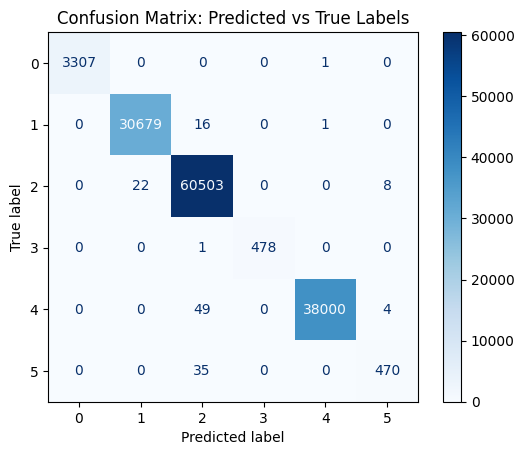

In [ ]:
# Predict class probabilities
pred = model.predict(x_test)

# Choose the class with the highest probability
pred_labels = pred.argmax(axis=1)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(y_test, pred_labels))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_labels))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Predicted vs True Labels")
plt.show()


c:\Users\lucch\Desktop\thesis-datasec\thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 201it [00:24,  6.24it/s]                         
C:\Users\lucch\AppData\Local\Temp\ipykernel_28064\414153472.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_test[:200], feature_names=x_test.columns)


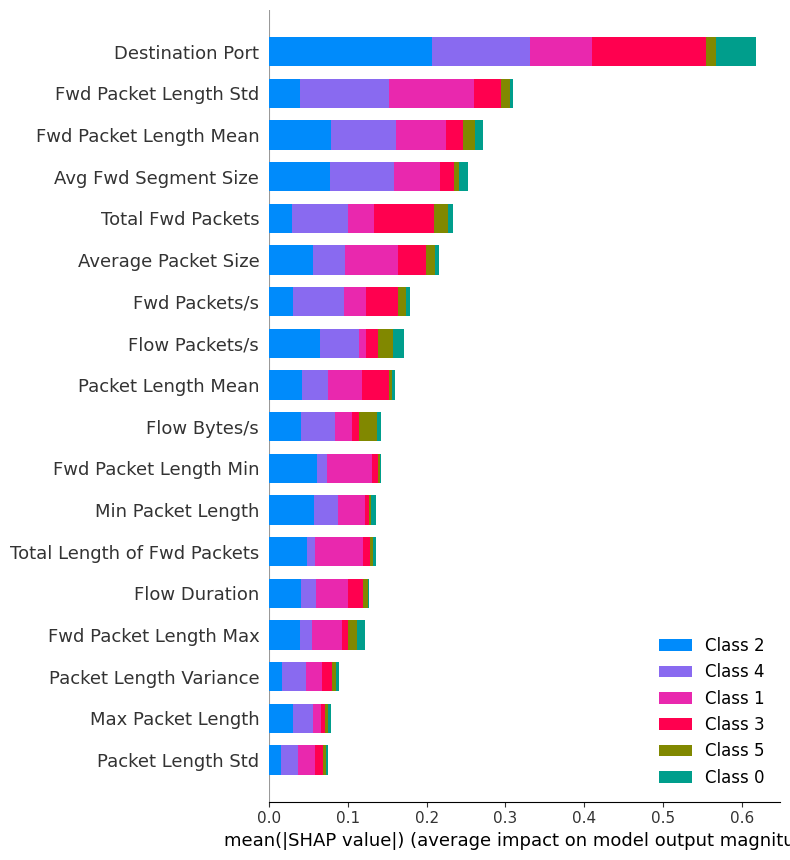

In [ ]:
import shap

background = x_train_small.iloc[np.random.choice(x_train_small.shape[0], 100, replace=False)]

explainer = shap.Explainer(model, background)
shap_values = explainer(x_test[:200])

shap.summary_plot(shap_values, x_test[:200], feature_names=x_test.columns)

# neural network

In [ ]:
class SelectiveConsistencyModel(tf.keras.Model):
    def __init__(self, base_model, lambda_consistency=0.3, noise_stddev=0.05):
        super().__init__()
        self.base_model = base_model
        self.lambda_consistency = lambda_consistency
        self.noise_stddev = noise_stddev
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs, training=False):
        return self.base_model(inputs, training=training)
        
    def train_step(self, data):
        (x_batch, labeled_mask), y_batch, sample_weight = data

        pseudo_mask = tf.logical_not(labeled_mask)
        noise = tf.random.normal(tf.shape(x_batch), mean=0.0, stddev=self.noise_stddev)
        x_aug = tf.where(tf.expand_dims(pseudo_mask, -1), x_batch + noise, x_batch)

        with tf.GradientTape() as tape:
            pred = self(x_batch, training=True)

            labeled_mask_float = tf.cast(labeled_mask, tf.float32)
            pseudo_mask_float = 1.0 - labeled_mask_float

            # -------- Labeled Supervised Loss --------
            labeled_indices = tf.where(labeled_mask)
            labeled_preds = tf.gather(pred, labeled_indices[:, 0])
            labeled_targets = tf.gather(y_batch, labeled_indices[:, 0])

            loss_labeled = tf.keras.losses.sparse_categorical_crossentropy(labeled_targets, labeled_preds)
            sample_weight_labeled = tf.gather(sample_weight, labeled_indices[:, 0])
            loss_labeled = tf.reduce_sum(loss_labeled * sample_weight_labeled)
            pseudo_indices = tf.where(pseudo_mask)

            def compute_kl_loss():
                pseudo_preds = tf.gather(pred, pseudo_indices[:, 0])
                # Convert hard labels to one-hot vectors for KL divergence
                pseudo_targets = tf.one_hot(tf.gather(y_batch, pseudo_indices[:, 0]), depth=pred.shape[-1])
                kl_loss_fn = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE)
                loss_kl = kl_loss_fn(pseudo_targets, pseudo_preds)
                sw = tf.gather(sample_weight, pseudo_indices[:, 0])
                return tf.reduce_sum(loss_kl * sw), tf.reduce_sum(sw)

            def zero_kl_loss():
                return tf.constant(0.0), tf.constant(0.0)

            loss_pseudo, sample_weight_pseudo = tf.cond(
                tf.shape(pseudo_indices)[0] > 0,
                true_fn=compute_kl_loss,
                false_fn=zero_kl_loss
            )

            # -------- Total Supervised Loss (normalized) --------
            total_samples = tf.reduce_sum(sample_weight_labeled) + sample_weight_pseudo + 1e-8
            loss_supervised = (loss_labeled + loss_pseudo) / total_samples

            # -------- Consistency Loss --------
            pred_aug = self(x_aug, training=True)
            consistency_mask = tf.expand_dims(pseudo_mask_float, -1)
            loss_consistency = tf.reduce_sum(tf.square(pred - pred_aug) * consistency_mask) / (
                tf.reduce_sum(pseudo_mask_float) + 1e-8
            )

            # -------- Total Loss --------
            total_loss = loss_supervised + self.lambda_consistency * loss_consistency

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.loss_tracker.update_state(total_loss)
        self.compiled_metrics.update_state(y_batch, pred)

        return {
            "loss": self.loss_tracker.result(),
            **{m.name: m.result() for m in self.metrics}
        }


    def test_step(self, data):
        x, y = data
        preds = self(x, training=False)
        loss = self.compute_loss(x, y, preds)
        for metric in self.metrics:
            metric.update_state(y, preds)

        return {
            "loss": loss,
            **{m.name: m.result() for m in self.metrics}
        }

In [ ]:
from tensorflow.keras import layers, models

def build_main_model(input_dim, num_classes, lambda_consistency=0.5, noise_stddev=0.02):
    inp = layers.Input(shape=(input_dim,))
    
    x = layers.Dense(256, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    out = layers.Dense(num_classes, activation='softmax')(x)

    base = Model(inp, out)
    return SelectiveConsistencyModel(base, lambda_consistency, noise_stddev)

In [ ]:
def build_parent_1(input_dim, num_classes, lambda_consistency=0.5, noise_stddev=0.02):
    inp = layers.Input(shape=(input_dim,))

    x = layers.Dense(90, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    res = layers.Dense(30, activation='relu')(x)
    res = layers.BatchNormalization()(res)
    res = layers.Dropout(0.2)(res)

    res = layers.Dense(30, activation=None)(res)
    res = layers.BatchNormalization()(res)

    x_proj = layers.Dense(30, activation=None)(x)
    x_proj = layers.BatchNormalization()(x_proj)

    x = layers.Add()([x_proj, res])
    x = layers.Activation('relu')(x)

    out = layers.Dense(num_classes, activation='softmax')(x)

    base = Model(inp, out)
    return SelectiveConsistencyModel(base, lambda_consistency, noise_stddev)

In [ ]:
from tensorflow.keras import layers, models

def build_parent_1(input_dim, num_classes, lambda_consistency=0.5, noise_stddev=0.02):
    inp = layers.Input(shape=(input_dim,))
    
    x = layers.Dense(90, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(30, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    out = layers.Dense(num_classes, activation='softmax')(x)

    base = Model(inp, out)
    return SelectiveConsistencyModel(base, lambda_consistency, noise_stddev)

In [ ]:
def select_balanced_pseudo_labels(pred_classes, pred_probs, high_conf_mask, max_samples_per_step, num_classes):
    per_class_limit = max_samples_per_step // num_classes
    selected_indices = []

    for cls in range(num_classes):
        cls_mask = (pred_classes == cls) & high_conf_mask
        cls_indices = np.where(cls_mask)[0]
        if len(cls_indices) == 0:
            continue

        cls_confidences = pred_probs[cls_indices, cls]
        top_cls_local_idx = np.argsort(-cls_confidences)[:per_class_limit]
        selected_indices.extend(cls_indices[top_cls_local_idx])

    return np.array(selected_indices)


In [ ]:
def train_with_curriculum(x_labeled, y_labeled, x_unlabeled, unlabeled_payload=None, y_unlabeled_true=None,
                          n_iters=5, threshold_start=0.95, threshold_end=0.4,
                          lambda_schedule=None, noise_schedule=None, max_samples_per_step=5000):
       
    thresholds = np.linspace(threshold_start, threshold_end, n_iters)
    x_train_curr = x_labeled.copy()
    y_train_curr = y_labeled.copy()
    x_unlabeled_pool = x_unlabeled.copy()
    y_unlabeled_true_pool = y_unlabeled_true.copy() if y_unlabeled_true is not None else None

    # variables to stop early when there is a sharp drop in the number of samples added
    last_n_selected_samples = []
    initial_sample_size = x_unlabeled_pool.shape[0]
    sharp_drop_detected = False
    sharp_drop_wait_counter = 0

    samples_added_per_iter = []
    pseudo_eval_df = pd.DataFrame(index=x_unlabeled.index)
    pseudo_eval_df['true_label'] = y_unlabeled_true
    pseudo_eval_df['predicted_label'] = np.nan

    if unlabeled_payload is not None:
        # assume unlabeled_payload is a Series or single-column DF with same index
        if isinstance(unlabeled_payload, pd.DataFrame) and unlabeled_payload.shape[1] == 1:
            pseudo_eval_df['payload'] = unlabeled_payload.iloc[:, 0]
        else:
            pseudo_eval_df['payload'] = unlabeled_payload

    val_acc = []

    # Store original class distribution for capping logic
    original_class_counts = dict(Counter(y_labeled))
    total_original = sum(original_class_counts.values())
    original_class_ratios = {
        cls: count / total_original for cls, count in original_class_counts.items()
    }

    # allow for different max sample selection schedule
    if isinstance(max_samples_per_step, int):
        max_samples_schedule = [max_samples_per_step] * n_iters
    else:
        max_samples_schedule = max_samples_per_step

    for step, curr_thresh in enumerate(thresholds):
        print(f"\n[Curriculum Step {step+1}] Threshold = {curr_thresh:.3f}")
        lambda_val = lambda_schedule[step] if lambda_schedule else 0.5
        noise_val = noise_schedule[step] if noise_schedule else 0.05

        print(f"→ λ = {lambda_val:.3f}, Noise STD = {noise_val:.3f}")

        class_counts = dict(Counter(y_train_curr))
        total = sum(class_counts.values())
        class_percentages = {cls: round(count / total * 100, 4) for cls, count in sorted(class_counts.items())}

        print(f"→ Class distribution in x_train_curr (%): {class_percentages}")

        if step == 0:
            tracked_classes = sorted(class_counts.keys())
            class_distribution_history = {cls: [] for cls in tracked_classes}

        for cls in tracked_classes:
            class_distribution_history[cls].append(class_percentages.get(cls, 0.0))

        if step == 0:
            # Cache labeled tensors for reuse
            x_labeled_tensor = tf.convert_to_tensor(x_labeled.values, dtype=tf.float32)
            y_labeled_tensor = tf.convert_to_tensor(y_labeled, dtype=tf.int32)
            sample_weights = compute_sample_weight('balanced', y=y_labeled)
            sample_weights_tensor = tf.convert_to_tensor(sample_weights, dtype=tf.float32)

            labeled_dataset = tf.data.Dataset.from_tensor_slices(
                ((x_labeled_tensor, tf.ones_like(y_labeled_tensor, dtype=tf.bool)),
                y_labeled_tensor, sample_weights_tensor)
            ).shuffle(10000).batch(32)

            # === Initial training of main model ===
            main_model = build_main_model(input_dim=x_labeled.shape[1],
                                        num_classes=len(np.unique(y_train_curr)),
                                        lambda_consistency=lambda_val,
                                        noise_stddev=noise_val)
            main_model.compile(optimizer='adam', metrics=['accuracy'])

            main_model.fit(labeled_dataset, epochs=7, verbose=1,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, min_delta=0.002)])

            # === Train parents initially ===
            parent_1 = build_parent_1(input_dim=x_train_curr.shape[1],
                                    num_classes=len(np.unique(y_train_curr)),
                                    lambda_consistency=lambda_val,
                                    noise_stddev=noise_val)

            for parent in [parent_1]:
                print(f"→ Training parent model {parent.name}")
                parent.compile(optimizer='adam', metrics=['accuracy'])
                parent.fit(labeled_dataset, epochs=5, verbose=1,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.001)])

        else:
            # === Curriculum step: pseudo-labeled data now included in x_train_curr / y_train_curr ===
            x_pseudo = x_train_curr.iloc[len(x_labeled):]
            y_pseudo = y_train_curr[len(y_labeled):]

            x_all = np.vstack([x_labeled.values, x_pseudo.values])
            y_all = np.concatenate([y_labeled, y_pseudo])

            labeled_mask = np.concatenate([
                np.ones(len(x_labeled), dtype=bool),
                np.zeros(len(x_pseudo), dtype=bool)
            ])

            # Weighting: Pseudo-labeled data gets lower confidence
            sample_weights = np.where(labeled_mask, 1.0, 0.5)
            balanced_weights = compute_sample_weight('balanced', y=y_all)
            sample_weights *= balanced_weights

            # Convert to tensors
            x_tensor = tf.convert_to_tensor(x_all, dtype=tf.float32)
            y_tensor = tf.convert_to_tensor(y_all, dtype=tf.int32)
            mask_tensor = tf.convert_to_tensor(labeled_mask, dtype=tf.bool)
            sample_weights_tensor = tf.convert_to_tensor(sample_weights, dtype=tf.float32)

            # Build training dataset
            train_dataset = tf.data.Dataset.from_tensor_slices(
                ((x_tensor, mask_tensor), y_tensor, sample_weights_tensor)
            ).shuffle(10000).batch(32)

            # === Fine-tune main model ===
            main_model.fit(train_dataset, epochs=5, verbose=1,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, min_delta=0.002)])

            # === Retrain parents every 3 steps ===
            if step % 3 == 0:
                parent_1 = build_parent_1(input_dim=x_train_curr.shape[1],
                                        num_classes=len(np.unique(y_train_curr)),
                                        lambda_consistency=lambda_val,
                                        noise_stddev=noise_val)

                for parent in [parent_1]:
                    print(f"→ Retraining parent model {parent.name}")
                    parent.compile(optimizer='adam', metrics=['accuracy'])
                    parent.fit(train_dataset, epochs=3, verbose=0,
                            callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

        if x_unlabeled_pool.empty:
            print("No unlabeled data left. Stopping early.")
            break

        pred_probs = main_model.predict(x_unlabeled_pool.values)
        parent_1_probs = parent_1.predict(x_unlabeled_pool.values)

        pred_classes = np.argmax(pred_probs, axis=1)
        parent_1_classes = np.argmax(parent_1_probs, axis=1)
        confidences = np.max(pred_probs, axis=1)

        top2_idx = np.argsort(pred_probs, axis=1)[:, -2:]

        top2_probs = np.take_along_axis(pred_probs, top2_idx, axis=1)
        top2_probs_norm = top2_probs / np.sum(top2_probs, axis=1, keepdims=True)
        choices = [np.random.choice(2, p=top2_probs_norm[i]) for i in range(len(top2_probs))]
        pred_classes = top2_idx[np.arange(len(top2_probs)), choices]

        # Full agreement: parents agree AND student matches them
        student_agreement = pred_classes == parent_1_classes
        print(f"→ Full agreement (student + both parents): ({np.sum(student_agreement)} samples)")

        sorted_preds = np.sort(pred_probs, axis=1)
        top1 = sorted_preds[:, -1]
        top2 = sorted_preds[:, -2] if pred_probs.shape[1] >= 2 else np.zeros_like(top1)
        margin = top1 - top2
        conf = (confidences >= curr_thresh)
        entropy = -np.sum(pred_probs * np.log(pred_probs + 1e-8), axis=1)

        top1_idx = np.argmax(pred_probs, axis=1)
        selected_is_top1 = pred_classes == top1_idx

        # high_conf_mask = (
        #     (selected_is_top1 & conf & (margin > 0.1) & (entropy < 0.3) & student_agreement) |
        #     (~selected_is_top1 & student_agreement)
        # )

        rand_mask = np.random.rand(len(pred_classes)) < 0.005

        high_conf_mask = (
            (selected_is_top1 & conf & (margin > 0.1) & (entropy < 0.3) & student_agreement) |
            (
                ~selected_is_top1 &
                (
                    (student_agreement & ~rand_mask) |
                    (rand_mask)
                )
            )
        )

        num_classes = pred_probs.shape[1]
        selected_indices = select_balanced_pseudo_labels(
            pred_classes=pred_classes,
            pred_probs=pred_probs,
            high_conf_mask=high_conf_mask,
            max_samples_per_step=max_samples_schedule[step],
            num_classes=num_classes
        )
        if len(selected_indices) == 0:
            print("→ No confident samples selected this step.")
            return thresholds[:len(samples_added_per_iter)], samples_added_per_iter, pseudo_eval_df, class_distribution_history
        else:
            selected_classes = pred_classes[selected_indices]
            class_counts = dict(Counter(selected_classes))
            print(f"→ Step {step}: Selected pseudo-label counts by class:")
            for cls in range(num_classes):
                print(f"   Class {cls}: {class_counts.get(cls, 0)} samples")

        x_high_conf = x_unlabeled_pool.iloc[selected_indices]
        y_high_conf = pred_classes[selected_indices]

        pseudo_eval_df.loc[x_high_conf.index, 'predicted_label'] = y_high_conf

        if y_unlabeled_true_pool is not None:
            y_true_new = y_unlabeled_true_pool.loc[x_high_conf.index]
            acc = accuracy_score(y_true_new, y_high_conf)
            print(f"→ Pseudo-label accuracy this step: {acc:.4f}")
            val_acc.append(acc)
            y_unlabeled_true_pool = y_unlabeled_true_pool.drop(index=x_high_conf.index)

        x_unlabeled_pool = x_unlabeled_pool.drop(index=x_high_conf.index)
        x_train_curr = pd.concat([x_train_curr, x_high_conf], axis=0)
        y_train_curr = np.concatenate([y_train_curr, y_high_conf], axis=0)

        samples_added_per_iter.append(len(y_high_conf))
        print(f"→ Added {len(y_high_conf)} pseudo-labeled samples (total: {len(x_train_curr)})")
        last_n_selected_samples.append(len(y_high_conf))
        print(f"→ Recent selected counts: {last_n_selected_samples}, sum of last 2: {sum(last_n_selected_samples[-2:])}")
        
        # check if there is a sharp decrease in the number of samples added
        if len(last_n_selected_samples) >= 3:
            recent_samples = last_n_selected_samples[-3:]
            if sum(recent_samples[-2:]) < 50:
                print("🛑 No recovery after sharp drop and sufficient samples used. Stopping early.")
                break

    return thresholds[:len(samples_added_per_iter)], samples_added_per_iter, pseudo_eval_df, class_distribution_history

In [ ]:
def plot_curriculum_progress(thresholds, sample_counts, val_accuracies=None):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Confidence Threshold')
    ax1.set_ylabel('# Pseudo-Labeled Samples', color='blue')
    ax1.plot(thresholds, sample_counts, marker='o', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.invert_xaxis()

    if val_accuracies:
        ax2 = ax1.twinx()
        ax2.set_ylabel('Validation Accuracy', color='green')
        ax2.plot(thresholds, val_accuracies, marker='s', linestyle='--', color='green')
        ax2.tick_params(axis='y', labelcolor='green')

    plt.title('Curriculum Learning Progress')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_class_distribution_over_time(class_distribution_history):
    plt.figure(figsize=(10, 6))
    for cls, values in class_distribution_history.items():
        plt.plot(range(1, len(values) + 1), values, label=f"Class {cls}")

    plt.xlabel("Curriculum Step")
    plt.ylabel("Class Percentage in x_train_curr (%)")
    plt.title("Class Distribution in Training Data Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

now with a different initial sample seed

In [ ]:
n_iters = 4
lambda_schedule = np.linspace(0.3, 0.05, n_iters).tolist()
noise_schedule = np.linspace(0.03, 0.01, n_iters).tolist()

max_samples_schedule = [len(x_unlabeled) // d for d in [20, 10, 5, 2]]
if len(max_samples_schedule) < n_iters:
    max_samples_schedule += [max_samples_schedule[-1]] * (n_iters - len(max_samples_schedule))

thresholds, counts, eval_df, class_distribution_history = train_with_curriculum(
    x_train,y_train, x_unlabeled, unlabeled_payload=payload_unlabeled,
    n_iters=n_iters,
    lambda_schedule=lambda_schedule,
    noise_schedule=noise_schedule,
    max_samples_per_step=max_samples_schedule
)


[Curriculum Step 1] Threshold = 0.950
→ λ = 0.300, Noise STD = 0.030
→ Class distribution in x_train_curr (%): {0: 2.4847, 1: 23.0676, 2: 45.1894, 3: 0.3573, 4: 28.5158, 5: 0.3852}
Epoch 1/7
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9588 - loss: 0.1660
Epoch 2/7
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.9871 - loss: 0.1630
Epoch 3/7
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.9891 - loss: 0.1628
Epoch 4/7
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9903 - loss: 0.1627
Epoch 5/7
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9909 - loss: 0.1627
Epoch 6/7
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9915 - loss: 0.1625
Epoch 7/7
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9912 - loss: 0.1626
→ Training parent model selective_consistency_model_1
Epoch 1/5
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9424 - loss: 0.1672
Epoch 2/5
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 2

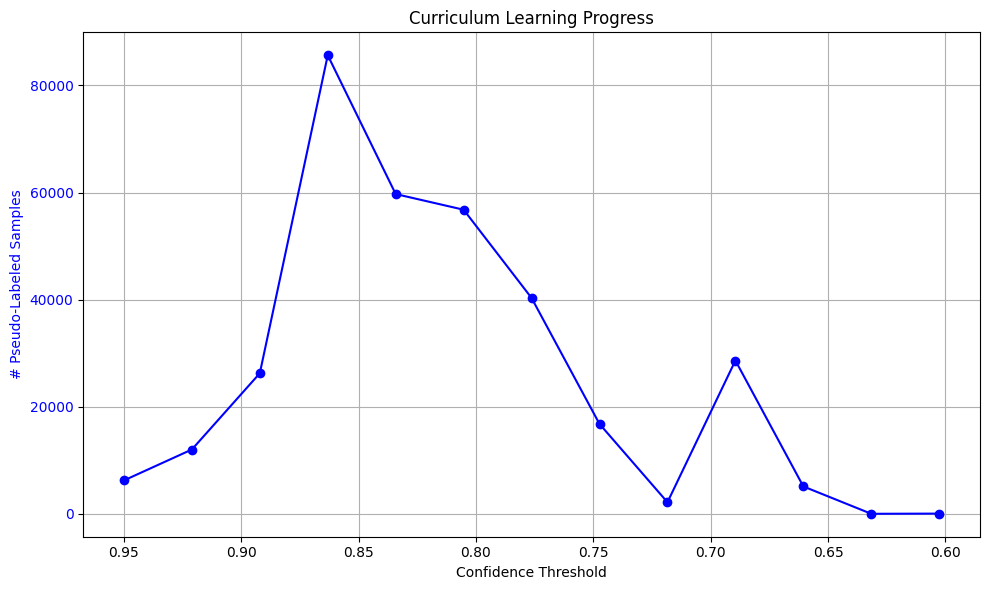

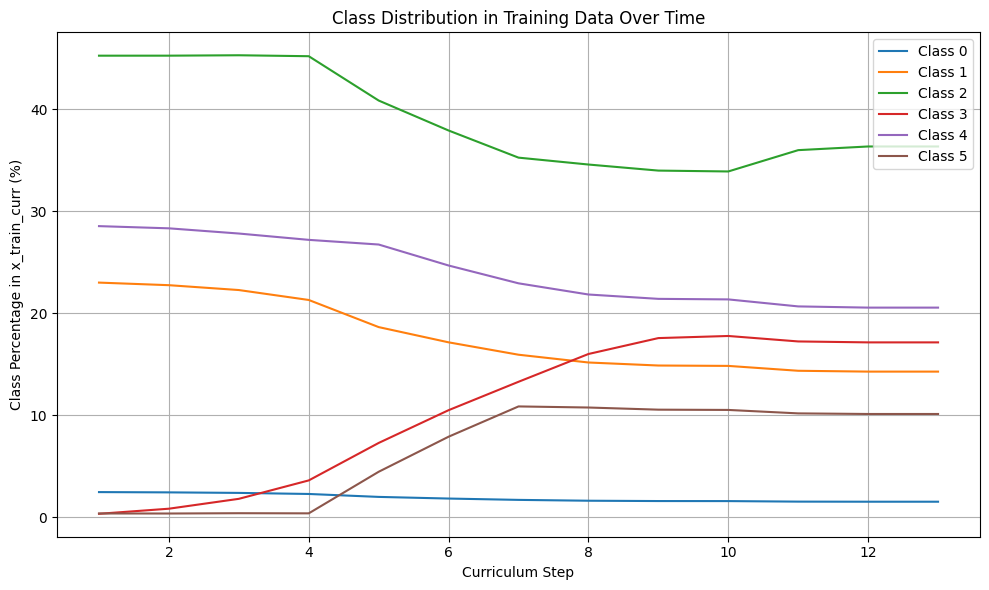

In [ ]:
plot_curriculum_progress(thresholds, counts)
plot_class_distribution_over_time(class_distribution_history)

In [46]:
eval_df["predicted_label"].value_counts()

predicted_label
3.0    82935
2.0    81047
0.0    80654
5.0    14127
4.0     3653
Name: count, dtype: int64

In [ ]:
# import pickle
# with open('data/pseudo_labeled_df.pkl', 'rb') as f:
#     df_unlabeled = pickle.load(f)
# with open('data/labeled_df.pkl', 'rb') as f:
#     df_labeled = pickle.load(f)
# eval_df = pd.DataFrame(index=df_unlabeled.index)
# eval_df["predicted_label"] = df_unlabeled["label"]
# eval_df["payload"] = df_unlabeled["payload"]
# x_unlabeled = df_unlabeled.drop(columns=["label", "source", "payload"])

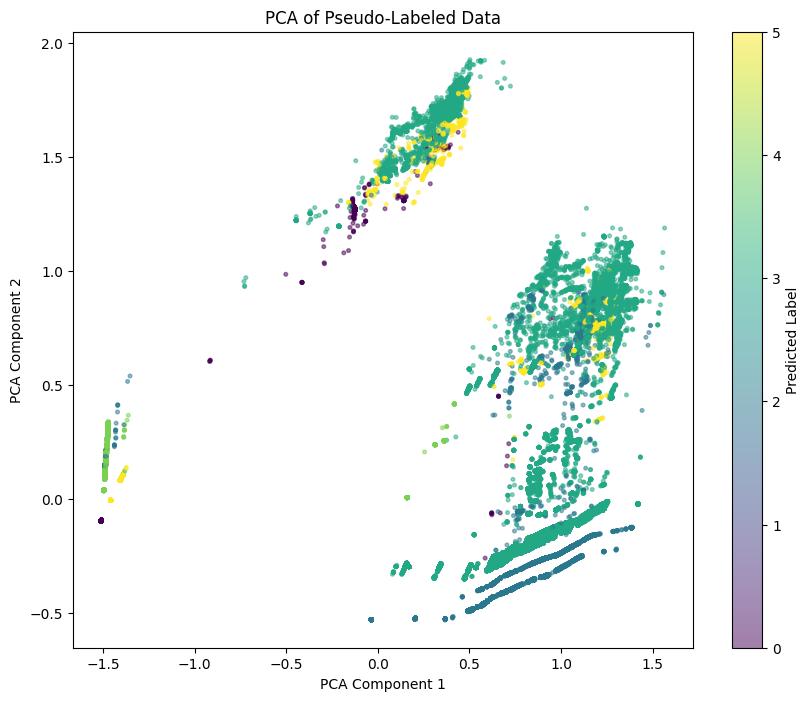

In [47]:
# pca plot of pseudo-labeled data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(x_unlabeled)
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=eval_df['predicted_label'], cmap='viridis', alpha=0.5, s=7)
plt.colorbar(label='Predicted Label')
plt.title('PCA of Pseudo-Labeled Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [57]:
df_labeled = x_labeled.copy()
df_labeled['label'] = y_labeled.values if isinstance(y_labeled, pd.Series) else y_labeled
df_labeled['source'] = 'Labeled'

# Step 2: Create a DataFrame from x_unlabeled with predicted labels and source info
df_unlabeled = x_unlabeled.copy()
df_unlabeled['label'] = eval_df['predicted_label'].values
df_unlabeled['source'] = 'Unlabeled'

# Step 3: Combine the two
df_combined = pd.concat([df_labeled, df_unlabeled], ignore_index=True)

# Step 4: PCA (no scaling needed)
feature_cols = df_combined.drop(columns=['label', 'source']).columns
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_combined[feature_cols])
df_combined['PCA1'] = X_pca[:, 0]
df_combined['PCA2'] = X_pca[:, 1]


In [58]:
df_unlabeled['payload'] = eval_df['payload']

In [42]:
with open('data/pseudo_labeled_df.pkl', 'wb') as f:
    pickle.dump(df_unlabeled, f)

In [43]:
with open('data/labeled_df.pkl', 'wb') as f:
    pickle.dump(df_labeled, f)

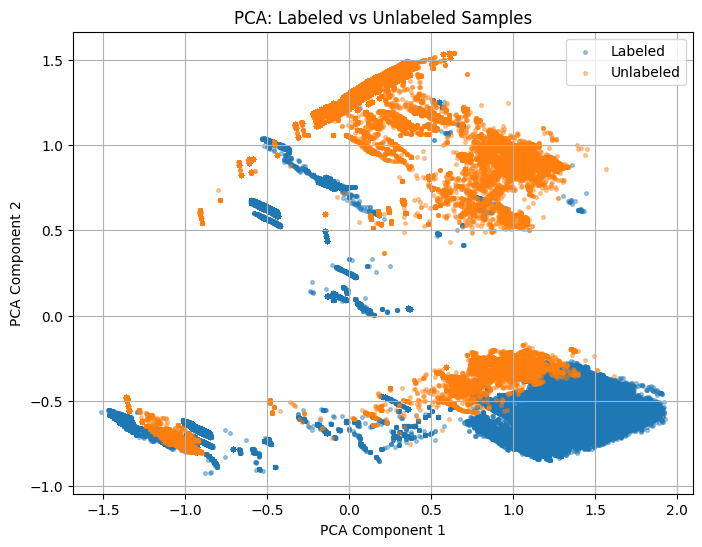

In [59]:
plt.figure(figsize=(8, 6))
for src in ['Labeled', 'Unlabeled']:
    subset = df_combined[df_combined['source'] == src]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=src, alpha=0.4, s=7)
plt.legend()
plt.title("PCA: Labeled vs Unlabeled Samples")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


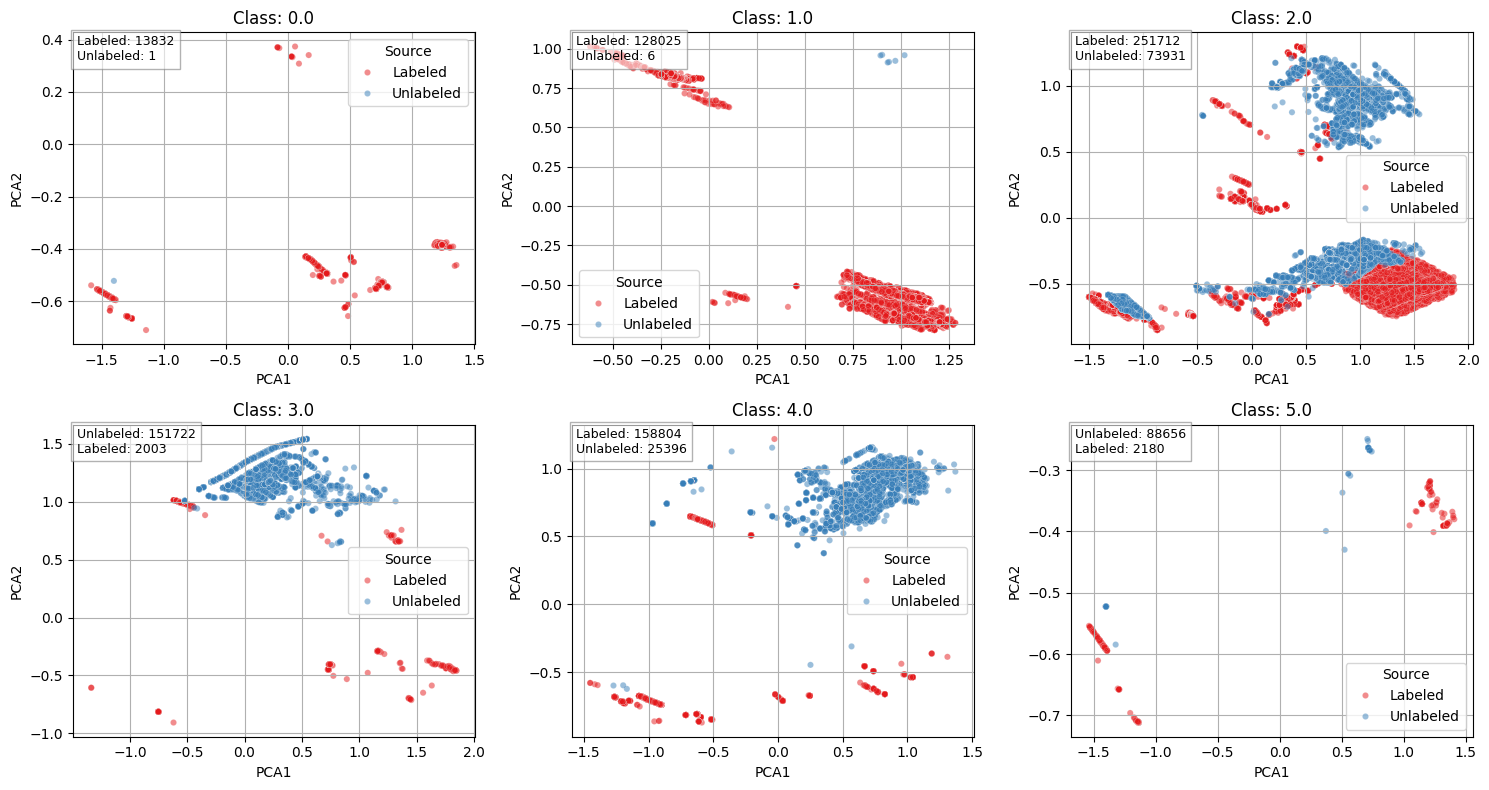

In [32]:
class_labels = df_combined["label"].unique()

# Set up subplots
n_classes = len(class_labels)
n_cols = 3
n_rows = -(-n_classes // n_cols)  # ceil division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

for idx, label in enumerate(sorted(class_labels)):
    ax = axes[idx // n_cols][idx % n_cols]
    
    df_class = df_combined[df_combined["label"] == label]
    
    sns.scatterplot(
        data=df_class,
        x="PCA1", y="PCA2",
        hue="source",  # labeled/unlabeled
        palette="Set1",
        alpha=0.5,
        s=20,
        ax=ax,
        linewidth=0.2
    )

    # Count labeled/unlabeled
    counts = df_class["source"].value_counts().to_dict()
    count_text = "\n".join([f"{src}: {count}" for src, count in counts.items()])

    # Add text in top left corner
    ax.text(
        0.01, 0.99, count_text,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='left',
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
    )

    ax.set_title(f"Class: {label}")
    ax.legend(title="Source")
    ax.grid(True)

# Remove unused axes
for i in range(n_classes, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

plt.tight_layout()
plt.show()


In [33]:
import umap

umap_model = umap.UMAP()
umap_result = umap_model.fit_transform(df_combined[feature_cols])
df_combined["UMAP1"] = umap_result[:, 0]
df_combined["UMAP2"] = umap_result[:, 1]

c:\Users\lucch\Desktop\thesis-datasec\thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\lucch\Desktop\thesis-datasec\thesis\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\lucch\Desktop\thesis-datasec\thesis\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\lucch\Desktop\thesis-datasec\thesis\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation 

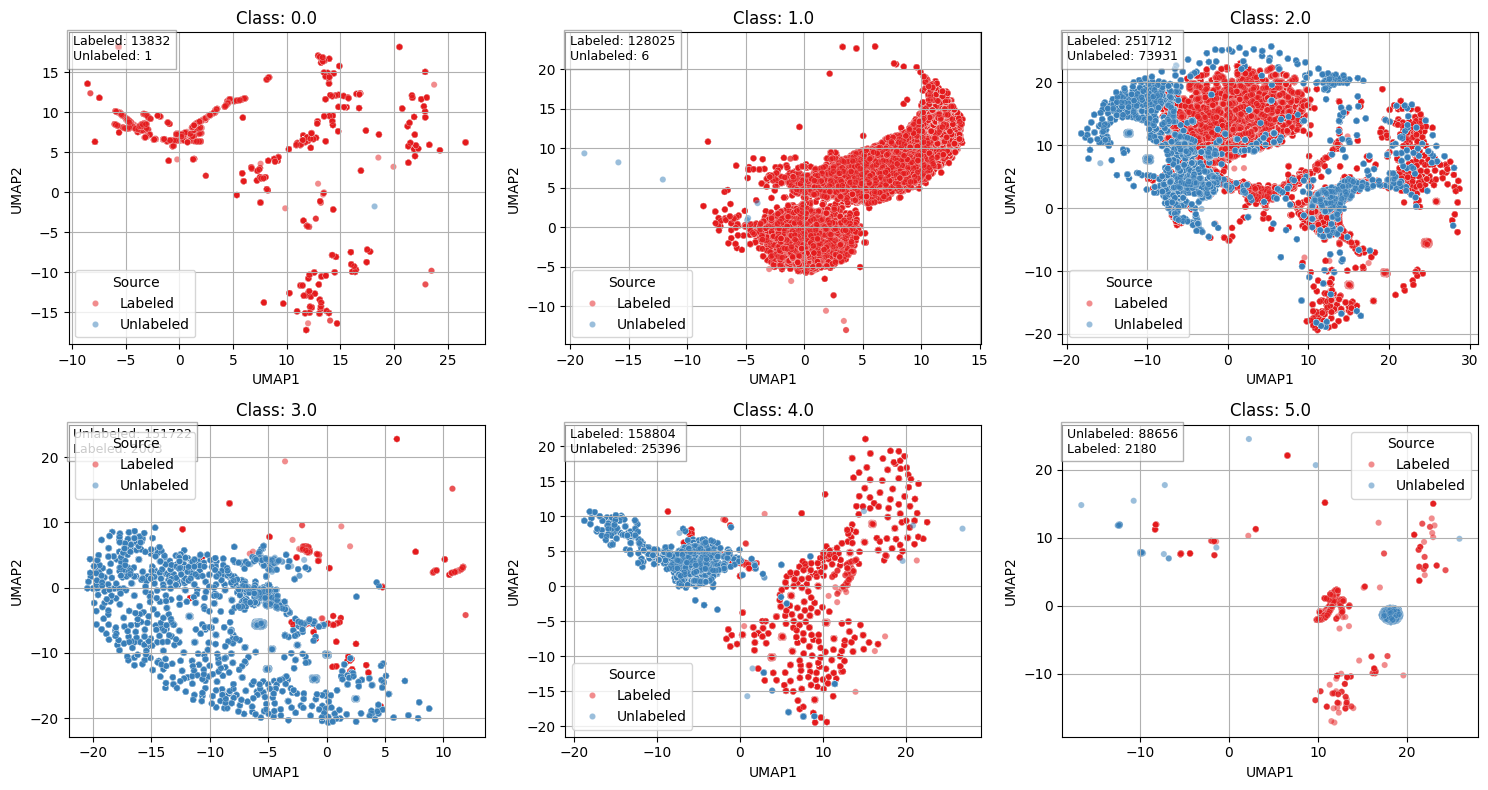

In [34]:
class_labels = df_combined["label"].unique()
n_classes = len(class_labels)
n_cols = 3
n_rows = -(-n_classes // n_cols)  # ceil division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

for idx, label in enumerate(sorted(class_labels)):
    ax = axes[idx // n_cols][idx % n_cols]
    
    df_class = df_combined[df_combined["label"] == label]
    
    sns.scatterplot(
        data=df_class,
        x="UMAP1", y="UMAP2",
        hue="source",  # e.g., labeled / unlabeled
        palette="Set1",
        alpha=0.5,
        s=20,
        ax=ax,
        linewidth=0.2
    )
    
    # Count labeled/unlabeled
    counts = df_class["source"].value_counts().to_dict()
    count_text = "\n".join([f"{src}: {count}" for src, count in counts.items()])
    
    ax.text(
        0.01, 0.99, count_text,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='left',
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
    )

    ax.set_title(f"Class: {label}")
    ax.legend(title="Source")
    ax.grid(True)

# Remove unused subplots
for i in range(n_classes, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

plt.tight_layout()
plt.show()


feed forward 3 layers 256-64, 0.6-0.25 lambda 0.01 noise 15 steps, 3 class proportianality, cnofidence threshold 0.995 to 0.85, scheduling max sample per step -->

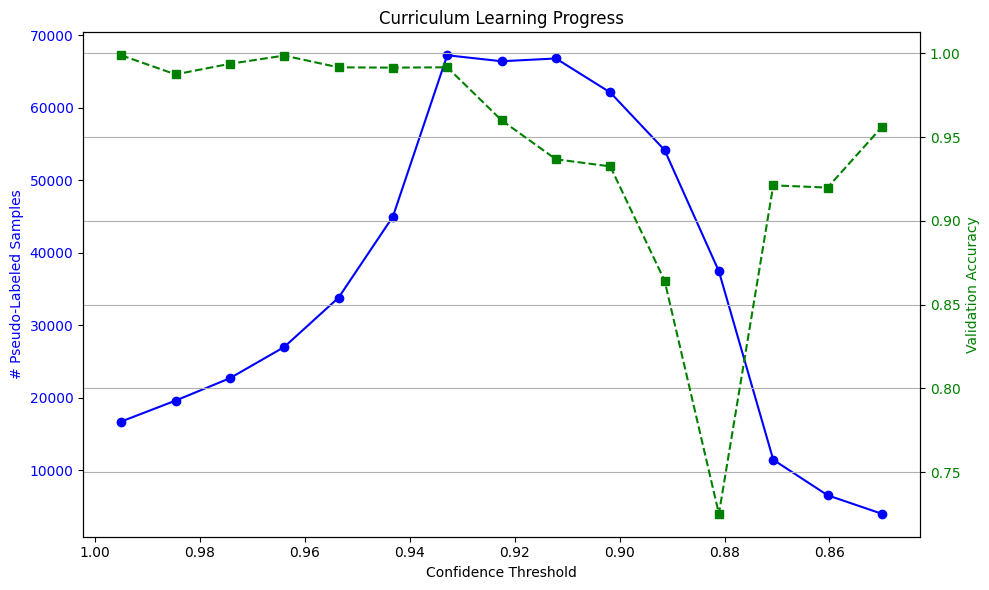

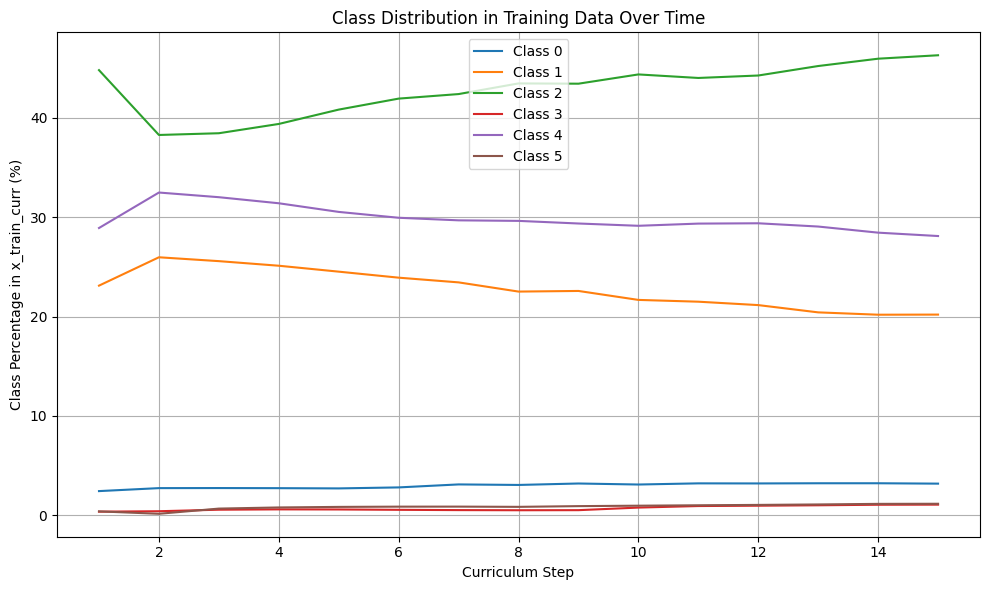

In [ ]:
plot_curriculum_progress(thresholds, counts, accs)
plot_class_distribution_over_time(class_distribution_history, thresholds)

In [ ]:
print(eval_df.isna().sum())
eval_df.dropna(subset=['predicted_label'], inplace=True)
y_true_final = eval_df['true_label'].astype(int)
y_pred_final = eval_df['predicted_label'].astype(int)

true_label            0
predicted_label    5944
dtype: int64


              precision    recall  f1-score   support

           0       0.76      0.95      0.84     13589
           1       0.99      0.85      0.92    125682
           2       0.93      0.97      0.95    241334
           3       0.33      0.99      0.50      1967
           4       1.00      0.97      0.98    155909
           5       0.28      0.84      0.42      2131

    accuracy                           0.94    540612
   macro avg       0.71      0.93      0.77    540612
weighted avg       0.95      0.94      0.94    540612



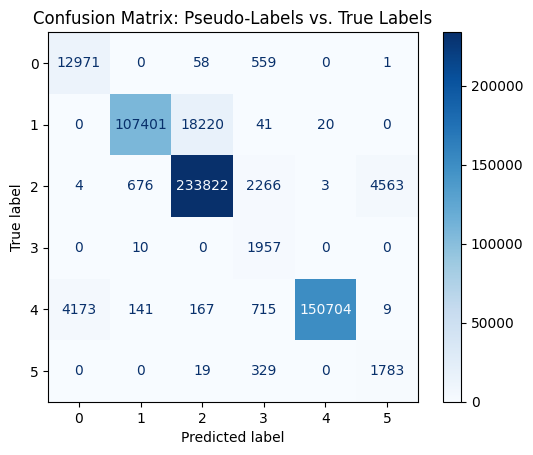

In [ ]:
print(classification_report(y_true_final, y_pred_final))

cm = confusion_matrix(y_true_final, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Pseudo-Labels vs. True Labels")
plt.show()
